 D√©tection de Pneumonie avec Transfer Learning  et MLflow
 Projet : Classification binaire d'images de radios thoraciques
 Auteur : [Bafod√© Jaiteh]
 Date : 25/05/2025

## üì¶ Pneumonia_Detection : 


### ‚ú® **OBJECTIF DU PROJET:  :**

‚úÖ Utiliser un mod√®le DenseNet121 pr√©-entra√Æn√© pour d√©tecter la pneumonie 
sur des radios thoraciques..  
‚úÖ Application du transfer learning pour am√©liorer la pr√©cision du mod√®le.
‚úÖ Utilisation de MLflow pour le suivi des exp√©riences et la gestion des mod√®les. 
‚úÖ Pr√©traitement des donn√©es avec augmentation pour am√©liorer la robustesse du mod√®le. 
‚úÖ Modelisation et √©valuation des performances du mod√®le sur un jeu de donn√©es de test.

---
---






## Configuration gpu

In [1]:
import tensorflow as tf
import os

# Configuration GPU stricte
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Configuration m√©moire GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Limite la m√©moire GPU √† 2GB
            tf.config.experimental.set_virtual_device_configuration(
                gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
            )
        print(f"‚úÖ GPU configur√©: {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"‚ùå Erreur GPU: {e}")

# Force l'utilisation CPU si GPU pose probl√®me
# tf.config.set_visible_devices([], 'GPU')  # D√©commentez si n√©cessaire

print("üîß Configuration GPU termin√©e")

üîß Configuration GPU termin√©e


In [2]:

# Configuration TensorFlow AVANT d'utiliser tf
print("üîß Configuration de TensorFlow...")

# Configuration de la m√©moire GPU (si disponible)
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"üöÄ GPU d√©tect√© et configur√©: {len(gpus)} GPU(s)")
    else:
        print("üíª Utilisation du CPU (aucun GPU d√©tect√©)")
except:
    print("üíª Configuration GPU non disponible, utilisation du CPU")

# Limitation de l'utilisation m√©moire pour stabilit√©
try:
    tf.config.threading.set_intra_op_parallelism_threads(2)
    tf.config.threading.set_inter_op_parallelism_threads(2)
    print("‚öôÔ∏è  Threads limit√©s pour optimiser la stabilit√©")
except:
    print("‚ö†Ô∏è  Configuration des threads non disponible")

üîß Configuration de TensorFlow...
üíª Utilisation du CPU (aucun GPU d√©tect√©)
‚öôÔ∏è  Threads limit√©s pour optimiser la stabilit√©


###  Import des biblioth√®ques et packages n√©c√©ssaire :

```

In [3]:
# Imports n√©cessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib
import os
from pathlib import Path
from tqdm import tqdm

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Flatten, BatchNormalization  
from tensorflow.keras.applications import DenseNet121, ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ReduceLROnPlateau, 
    ModelCheckpoint,
    TensorBoard
)

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report
)

# MLflow 
import mlflow
import mlflow.tensorflow
# Configuration
DATA_PATH = Path("data/chest_xray")
print(f" Imports charg√©s")
print(f" DATA_PATH: {DATA_PATH} (existe: {DATA_PATH.exists()})")
print(" Tous les imports r√©ussis")

 Imports charg√©s
 DATA_PATH: data\chest_xray (existe: True)
 Tous les imports r√©ussis


## Param√®tres globaux

In [4]:

IMG_SIZE = (224, 224)  # Taille d'entr√©e pour DenseNet121
BATCH_SIZE = 32        # Batch size r√©duit pour DenseNet (plus lourd)
EPOCHS = 75
LEARNING_RATE = 0.00005

In [5]:
# Chemins des donn√©es
# Le dataset est dans le dossier data/chest_xray
DATA_PATH = "data/chest_xray"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val") 
TEST_PATH = os.path.join(DATA_PATH, "test")

## Chemins des donn√©es

In [6]:
# Structure attendue : chest_xray/train/NORMAL et chest_xray/train/PNEUMONIA
DATA_PATH = "chest_xray"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val") 
TEST_PATH = os.path.join(DATA_PATH, "test")

## Exploration et pr√©paration des donn√©es 

In [7]:

  

def explore_dataset(data_path):
    """
    Explore la structure du dataset et affiche des statistiques
    """
    print(f"\nüîç EXPLORATION DU DATASET")
    print("=" * 50)
    
    if not os.path.exists(data_path):
        print(f"‚ö†Ô∏è  Le dossier {data_path} n'existe pas.")
        print("üì• V√©rifiez que le dataset est bien dans le dossier 'data/chest_xray'")
        print("üìÅ Structure attendue: data/chest_xray/train/, data/chest_xray/val/, data/chest_xray/test/")
        print("‚ùå Exploration impossible.")
        return False
    
    total_images = 0
    dataset_info = {}
    
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(data_path, subset)
        if os.path.exists(subset_path):
            print(f"\nüìÇ Dossier {subset.upper()}:")
            subset_total = 0
            dataset_info[subset] = {}
            
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_path = os.path.join(subset_path, class_name)
                if os.path.exists(class_path):
                    count = len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                    print(f"  - {class_name}: {count} images")
                    dataset_info[subset][class_name] = count
                    subset_total += count
                else:
                    print(f"  - {class_name}: Dossier manquant ‚ùå")
                    dataset_info[subset][class_name] = 0
            
            print(f"  Total {subset}: {subset_total} images")
            total_images += subset_total
        else:
            print(f"\nüìÇ Dossier {subset.upper()}: Manquant ‚ùå")
    
    if total_images > 0:
        print(f"\nüìä R√âSUM√â DU DATASET:")
        print(f"  üéØ Total: {total_images} images")
        
        # Calcul des pourcentages
        total_normal = sum([dataset_info[s].get('NORMAL', 0) for s in dataset_info])
        total_pneumonia = sum([dataset_info[s].get('PNEUMONIA', 0) for s in dataset_info])
        
        if total_images > 0:
            normal_pct = (total_normal / total_images) * 100
            pneumonia_pct = (total_pneumonia / total_images) * 100
            print(f"  ü´Å NORMAL: {total_normal} ({normal_pct:.1f}%)")
            print(f"  ü¶† PNEUMONIA: {total_pneumonia} ({pneumonia_pct:.1f}%)")
            
            if abs(normal_pct - pneumonia_pct) > 20:
                print(f"  ‚ö†Ô∏è  Dataset d√©s√©quilibr√© d√©tect√©!")
    
    return total_images > 0

def create_demo_dataset():
    """
    Cr√©e un dataset de d√©monstration avec des images synth√©tiques
    pour tester le code sans t√©l√©charger le vrai dataset
    """
    print(f"\nüß™ CR√âATION D'UN DATASET DE D√âMONSTRATION")
    print("=" * 50)
    
    demo_path = "demo_chest_xray"
    
    if os.path.exists(demo_path):
        print(f"‚úÖ Dataset de d√©mo existe d√©j√†: {demo_path}")
        return demo_path
    
    try:
        # Cr√©ation de la structure
        for subset in ['train', 'val', 'test']:
            for class_name in ['NORMAL', 'PNEUMONIA']:
                os.makedirs(os.path.join(demo_path, subset, class_name), exist_ok=True)
        
        # G√©n√©ration d'images synth√©tiques
        print("üîÑ G√©n√©ration d'images synth√©tiques...")
        
        import numpy as np
        from PIL import Image
        
        # Nombre d'images par cat√©gorie
        counts = {
            'train': {'NORMAL': 20, 'PNEUMONIA': 30},
            'val': {'NORMAL': 5, 'PNEUMONIA': 8},
            'test': {'NORMAL': 10, 'PNEUMONIA': 15}
        }
        
        for subset, class_counts in counts.items():
            for class_name, count in class_counts.items():
                for i in range(count):
                    # G√©n√©ration d'image synth√©tique
                    if class_name == 'NORMAL':
                        # Images plus claires pour "normal"
                        img_array = np.random.randint(100, 200, (224, 224), dtype=np.uint8)
                    else:
                        # Images avec plus de variation pour "pneumonia"
                        img_array = np.random.randint(50, 150, (224, 224), dtype=np.uint8)
                        # Ajout de quelques "taches" pour simuler
                        for _ in range(5):
                            x, y = np.random.randint(0, 200, 2)
                            img_array[x:x+24, y:y+24] = np.random.randint(20, 80)
                    
                    # Sauvegarde
                    img = Image.fromarray(img_array, mode='L')
                    filename = f"{class_name.lower()}_{i+1:03d}.jpg"
                    filepath = os.path.join(demo_path, subset, class_name, filename)
                    img.save(filepath)
        
        print(f"‚úÖ Dataset de d√©mo cr√©√©: {demo_path}")
        print("‚ö†Ô∏è  Note: Ce sont des images synth√©tiques pour tester le code uniquement!")
        return demo_path
        
    except Exception as e:
        print(f"‚ùå Erreur lors de la cr√©ation du dataset de d√©mo: {e}")
        return None

# Exploration du dataset principal
print("üéØ RECHERCHE DU DATASET PRINCIPAL...")
dataset_exists = explore_dataset(DATA_PATH)

# Si pas de dataset principal, proposer le dataset de d√©mo
if not dataset_exists:
    print(f"\nüí° SOLUTION TEMPORAIRE: DATASET DE D√âMONSTRATION")
    print("=" * 60)
    print("En attendant de t√©l√©charger le vrai dataset, voulez-vous:")
    print("1. üß™ Cr√©er un dataset de d√©monstration pour tester le code")
    print("2. ‚è≠Ô∏è  Passer cette √©tape et continuer sans donn√©es")
    print()
    
    # Cr√©ation automatique du dataset de d√©mo pour la d√©monstration
    demo_path = create_demo_dataset()
    if demo_path:
        print(f"\nüîÑ Utilisation du dataset de d√©mo pour la suite...")
        DATA_PATH = demo_path
        TRAIN_PATH = os.path.join(DATA_PATH, "train")
        VAL_PATH = os.path.join(DATA_PATH, "val")
        TEST_PATH = os.path.join(DATA_PATH, "test")
        dataset_exists = True
        print(f"‚úÖ Chemins mis √† jour vers le dataset de d√©mo")
    else:
        print(f"‚ùå Impossible de cr√©er le dataset de d√©mo")
        
print(f"\nüìÅ CHEMINS FINAUX:")
print(f"  - Dataset: {DATA_PATH}")
print(f"  - Entra√Ænement: {TRAIN_PATH}")
print(f"  - Validation: {VAL_PATH}")
print(f"  - Test: {TEST_PATH}")
print(f"  - Dataset disponible: {'‚úÖ Oui' if dataset_exists else '‚ùå Non'}")

üéØ RECHERCHE DU DATASET PRINCIPAL...

üîç EXPLORATION DU DATASET
‚ö†Ô∏è  Le dossier chest_xray n'existe pas.
üì• V√©rifiez que le dataset est bien dans le dossier 'data/chest_xray'
üìÅ Structure attendue: data/chest_xray/train/, data/chest_xray/val/, data/chest_xray/test/
‚ùå Exploration impossible.

üí° SOLUTION TEMPORAIRE: DATASET DE D√âMONSTRATION
En attendant de t√©l√©charger le vrai dataset, voulez-vous:
1. üß™ Cr√©er un dataset de d√©monstration pour tester le code
2. ‚è≠Ô∏è  Passer cette √©tape et continuer sans donn√©es


üß™ CR√âATION D'UN DATASET DE D√âMONSTRATION
‚úÖ Dataset de d√©mo existe d√©j√†: demo_chest_xray

üîÑ Utilisation du dataset de d√©mo pour la suite...
‚úÖ Chemins mis √† jour vers le dataset de d√©mo

üìÅ CHEMINS FINAUX:
  - Dataset: demo_chest_xray
  - Entra√Ænement: demo_chest_xray\train
  - Validation: demo_chest_xray\val
  - Test: demo_chest_xray\test
  - Dataset disponible: ‚úÖ Oui


In [8]:

import tensorflow as tf
print('‚úÖ TensorFlow CPU version:', tf.__version__)
print('‚úÖ Python version:', __import__('sys').version.split()[0])

# Test simple
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(10,))])
x = tf.random.normal((32, 10))
y = model(x)
print('‚úÖ Test r√©ussi - Shape:', y.shape)
print('üéâ TensorFlow fonctionne parfaitement!')


‚úÖ TensorFlow CPU version: 2.13.0
‚úÖ Python version: 3.10.11
‚úÖ Test r√©ussi - Shape: (32, 1)
üéâ TensorFlow fonctionne parfaitement!


# CR√âATION DES G√âN√âRATEURS DE DONN√âES AVEC IMAGEDATAGENERATOR

In [9]:
def create_data_generators():
    """
    Cr√©e les g√©n√©rateurs de donn√©es avec ImageDataGenerator
    """
    print("\nüîÑ CR√âATION DES G√âN√âRATEURS DE DONN√âES")
    print("=" * 50)
    
    # G√©n√©rateur pour l'entra√Ænement avec augmentation de donn√©es
    train_datagen = ImageDataGenerator(
        rescale=1./255,                    # Normalisation [0,1]
        rotation_range=15,                 # Rotation ¬±15¬∞
        width_shift_range=0.1,             # D√©calage horizontal 10%
        height_shift_range=0.1,            # D√©calage vertical 10%
        shear_range=0.1,                   # Cisaillement
        zoom_range=0.1,                    # Zoom ¬±10%
        horizontal_flip=True,              # Retournement horizontal
        vertical_flip=False,               # Pas de retournement vertical pour les radios
        fill_mode='nearest',               # Remplissage pixels
        brightness_range=[0.8, 1.2]       # Variation luminosit√©
    )
    
    # G√©n√©rateur pour validation et test (sans augmentation)
    val_test_datagen = ImageDataGenerator(
        rescale=1./255  # Seulement normalisation
    )
    
    print("üìã Param√®tres d'augmentation configur√©s:")
    print("  - Rotation: ¬±15¬∞")
    print("  - D√©calages: ¬±10%")
    print("  - Zoom: ¬±10%")
    print("  - Retournement horizontal: Oui")
    print("  - Variation luminosit√©: 0.8-1.2")
    
    try:
        # G√©n√©rateur d'entra√Ænement
        train_generator = train_datagen.flow_from_directory(
            TRAIN_PATH,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',  # Classification binaire
            shuffle=True,
            seed=42
        )
        
        # G√©n√©rateur de validation
        val_generator = val_test_datagen.flow_from_directory(
            VAL_PATH,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )
        
        # G√©n√©rateur de test
        test_generator = val_test_datagen.flow_from_directory(
            TEST_PATH,
            target_size=IMG_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='binary',
            shuffle=False
        )
        
        print("\n‚úÖ G√©n√©rateurs cr√©√©s avec succ√®s!")
        print(f"üìù Classes d√©tect√©es: {train_generator.class_indices}")
        print(f"üî¢ Nombre de batches d'entra√Ænement: {len(train_generator)}")
        print(f"üî¢ Nombre de batches de validation: {len(val_generator)}")
        print(f"üî¢ Nombre de batches de test: {len(test_generator)}")
        
        return train_generator, val_generator, test_generator
        
    except Exception as e:
        print(f"‚ùå Erreur lors de la cr√©ation des g√©n√©rateurs: {e}")
        print("üí° V√©rifiez la structure des dossiers et la pr√©sence des images")
        return None, None, None

# Cr√©ation des g√©n√©rateurs
if dataset_exists:
    train_gen, val_gen, test_gen = create_data_generators()
else:
    train_gen, val_gen, test_gen = None, None, None


üîÑ CR√âATION DES G√âN√âRATEURS DE DONN√âES
üìã Param√®tres d'augmentation configur√©s:
  - Rotation: ¬±15¬∞
  - D√©calages: ¬±10%
  - Zoom: ¬±10%
  - Retournement horizontal: Oui
  - Variation luminosit√©: 0.8-1.2
Found 50 images belonging to 2 classes.
Found 13 images belonging to 2 classes.
Found 25 images belonging to 2 classes.

‚úÖ G√©n√©rateurs cr√©√©s avec succ√®s!
üìù Classes d√©tect√©es: {'NORMAL': 0, 'PNEUMONIA': 1}
üî¢ Nombre de batches d'entra√Ænement: 2
üî¢ Nombre de batches de validation: 1
üî¢ Nombre de batches de test: 1


## Visualisation d'√©chantillon d'images 


  VISUALISATION D'√âCHANTILLONS
 R√©cup√©ration d'un batch d'images...
 Batch r√©cup√©r√© - Shape: (32, 224, 224, 3), Labels: (32,)
 Range des pixels: [0.004, 0.992]


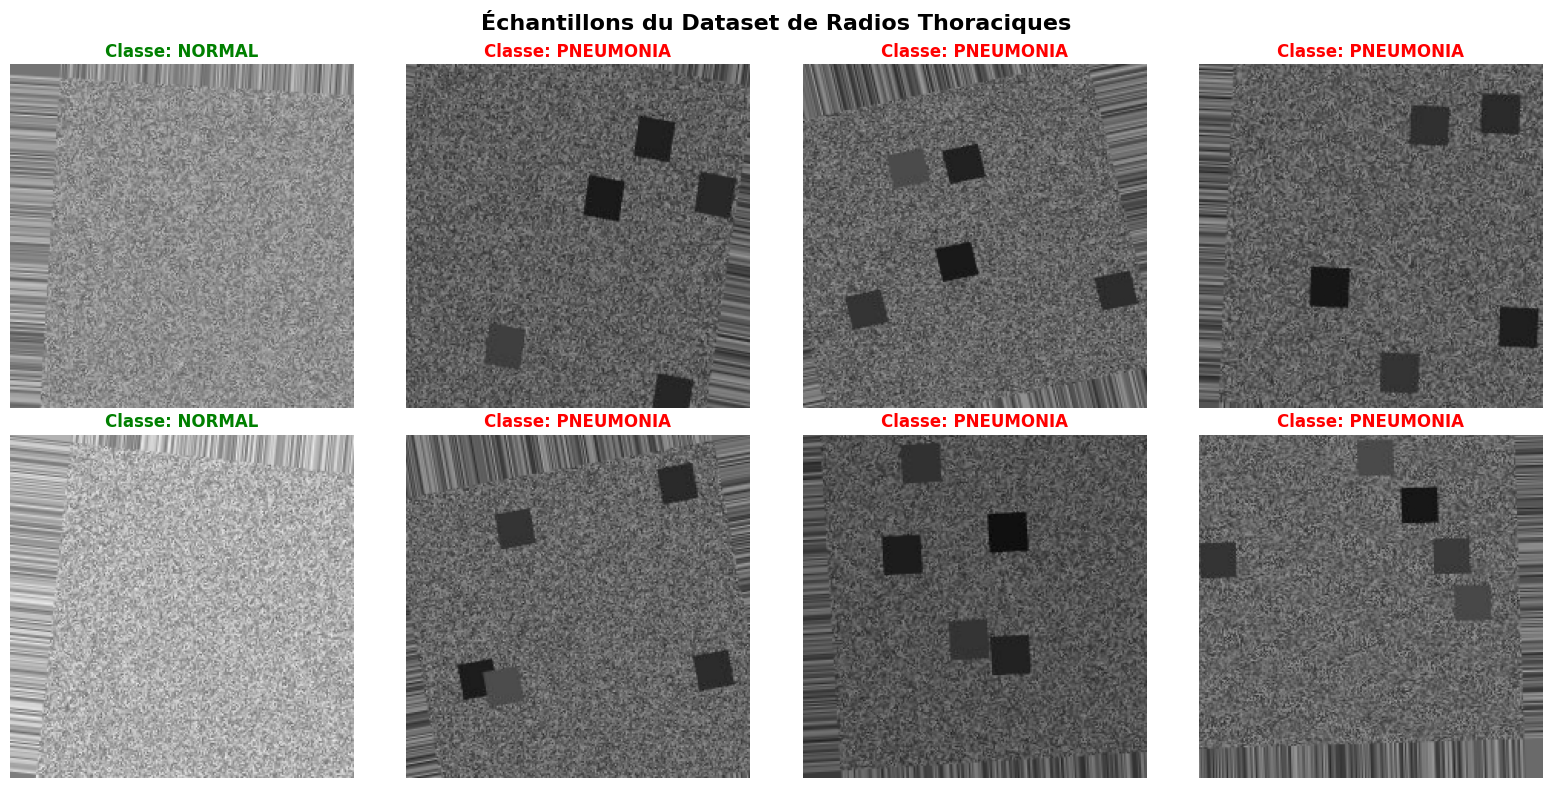

‚úÖ Visualisation termin√©e!


In [10]:
def visualize_samples(generator, num_samples=8):
    """
    Affiche quelques √©chantillons du dataset avec leurs labels
    """
    if generator is None:
        print("‚ö†Ô∏è  G√©n√©rateur non disponible pour la visualisation")
        return
        
    print(f"\n  VISUALISATION D'√âCHANTILLONS")
    print("=" * 50)
    
    try:
        # Reset du g√©n√©rateur pour √©viter les probl√®mes
        generator.reset()
        
        # R√©cup√©ration d'un batch
        print(" R√©cup√©ration d'un batch d'images...")
        batch_images, batch_labels = next(generator)
        
        print(f" Batch r√©cup√©r√© - Shape: {batch_images.shape}, Labels: {batch_labels.shape}")
        print(f" Range des pixels: [{batch_images.min():.3f}, {batch_images.max():.3f}]")
        
        # Configuration de matplotlib
        plt.style.use('default')  # Reset du style
        
        # Configuration de la figure
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle("√âchantillons du Dataset de Radios Thoraciques", fontsize=16, fontweight='bold')
        
        # Aplatir les axes pour faciliter l'it√©ration
        axes = axes.flatten()
        
        for i in range(min(num_samples, len(batch_images))):
            # Affichage de l'image
            img = batch_images[i]
            
            # V√©rification si l'image est en couleur ou niveaux de gris
            if len(img.shape) == 3 and img.shape[-1] == 3:
                # Image couleur
                axes[i].imshow(img)
            else:
                # Image en niveaux de gris
                if len(img.shape) == 3:
                    img = img[:,:,0]  # Prendre le premier canal
                axes[i].imshow(img, cmap='gray')
            
            # D√©termination de la classe et couleur
            label = "PNEUMONIA" if batch_labels[i] == 1 else "NORMAL"
            color = "red" if batch_labels[i] == 1 else "green"
            
            # Ajout du titre avec la classe
            axes[i].set_title(f"Classe: {label}", color=color, fontsize=12, fontweight='bold')
            axes[i].axis('off')
        
        # Masquer les sous-graphiques non utilis√©s
        for i in range(num_samples, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        
        # Force l'affichage
        plt.show()
        
        print("‚úÖ Visualisation termin√©e!")
        
    except Exception as e:
        print(f" Erreur lors de la visualisation: {e}")
        print(" Causes possibles:")
        print("  - Dataset non trouv√© ou mal structur√©")
        print("  - Probl√®me avec les g√©n√©rateurs de donn√©es")
        print("  - Probl√®me d'affichage matplotlib")

# Visualisation des √©chantillons
if train_gen is not None:
    visualize_samples(train_gen)

** Cr√©ation du mod√®le avec Transfer Learning **

In [11]:
def create_densenet_model():
    """
    Cr√©e un mod√®le utilisant DenseNet121 pr√©-entra√Æn√© avec transfer learning
    """
    print(f"\n CR√âATION DU MOD√àLE AVEC DENSENET121")
    print("=" * 50)
    
    try:
        # Nettoyage de la m√©moire
        tf.keras.backend.clear_session()
        
        # Chargement du mod√®le DenseNet121 pr√©-entra√Æn√©
        print("üì• Chargement de DenseNet121 pr√©-entra√Æn√©...")
        base_model = DenseNet121(
            weights='imagenet',        # Poids pr√©-entra√Æn√©s sur ImageNet
            include_top=False,         # Exclusion de la couche de classification
            input_shape=(*IMG_SIZE, 3), # Forme d'entr√©e (224, 224, 3)
            pooling=None               # Pas de pooling automatique
        )
        
        # Gel des couches pr√©-entra√Æn√©es pour le transfer learning
        base_model.trainable = False
        
        print(f"üìä Mod√®le de base DenseNet121:")
        print(f"  - Nombre de couches: {len(base_model.layers)}")
        print(f"  - Param√®tres totaux: {base_model.count_params():,}")
        print(f"  - Param√®tres entra√Ænables: {sum([tf.keras.backend.count_params(w) for w in base_model.trainable_weights]):,}")
        
        # Construction du mod√®le complet
        inputs = base_model.input
        x = base_model.output
        
        # Ajout de couches personnalis√©es pour la classification binaire
        x = GlobalAveragePooling2D(name='global_avg_pooling')(x)
        x = Dense(256, activation='relu', name='dense_256')(x)
        x = Dropout(0.5, name='dropout_0.5')(x)
        x = Dense(128, activation='relu', name='dense_128')(x)
        x = Dropout(0.3, name='dropout_0.3')(x)
        
        # Couche de sortie pour classification binaire
        outputs = Dense(1, activation='sigmoid', name='predictions')(x)
        
        # Cr√©ation du mod√®le final
        model = Model(inputs, outputs, name='DenseNet121_Pneumonia')
        
        # Compilation du mod√®le (CORRIG√âE pour √©viter les erreurs)
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']  # Seulement accuracy pour √©viter les bugs TensorFlow
        )
        
        print(f" Mod√®le cr√©√© et compil√©!")
        print(f" Optimiseur: Adam (lr={LEARNING_RATE})")
        print(f" Fonction de perte: binary_crossentropy")
        print(f" M√©triques: accuracy")
        print(f" Param√®tres entra√Ænables totaux: {model.count_params():,}")
        
        return model
        
    except Exception as e:
        print(f" Erreur lors de la cr√©ation du mod√®le: {e}")
        print(" Essayons avec un mod√®le plus simple...")
        return create_simple_fallback_model()

def create_simple_fallback_model():
    """
    Cr√©e un mod√®le CNN simple en cas de probl√®me avec DenseNet121
    """
    print(f"\n  MOD√àLE CNN SIMPLE DE SECOURS")
    print("=" * 50)
    
    try:
        # Nettoyage de la m√©moire
        tf.keras.backend.clear_session()
        
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(*IMG_SIZE, 3)),
            
            # Normalisation
            tf.keras.layers.Rescaling(1./255),
            
            # Bloc 1
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(2),
            
            # Bloc 2
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(2),
            
            # Bloc 3
            tf.keras.layers.Conv2D(128, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(2),
            
            # Classification
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ], name='Simple_CNN_Pneumonia')
        
        # Compilation
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        print(f" Mod√®le CNN simple cr√©√©!")
        print(f" Param√®tres totaux: {model.count_params():,}")
        print(f"  Mod√®le de secours pour √©viter les probl√®mes")
        
        return model
        
    except Exception as e:
        print(f" Erreur critique: {e}")
        return None

# Cr√©ation du mod√®le avec gestion des erreurs
if dataset_exists:
    print(" TENTATIVE DE CR√âATION DU MOD√àLE...")
    model = create_densenet_model()
    
    if model is not None:
        # Affichage du r√©sum√© du mod√®le (version courte)
        print(f"\n R√âSUM√â DU MOD√àLE")
        print("=" * 50)
        print(f" Nom: {model.name}")
        print(f" Entr√©e: {model.input_shape}")
        print(f" Sortie: {model.output_shape}")
        print(f" Param√®tres totaux: {model.count_params():,}")



 TENTATIVE DE CR√âATION DU MOD√àLE...

 CR√âATION DU MOD√àLE AVEC DENSENET121
üì• Chargement de DenseNet121 pr√©-entra√Æn√©...
üìä Mod√®le de base DenseNet121:
  - Nombre de couches: 427
  - Param√®tres totaux: 7,037,504
  - Param√®tres entra√Ænables: 0
 Mod√®le cr√©√© et compil√©!
 Optimiseur: Adam (lr=5e-05)
 Fonction de perte: binary_crossentropy
 M√©triques: accuracy
 Param√®tres entra√Ænables totaux: 7,332,929

 R√âSUM√â DU MOD√àLE
 Nom: DenseNet121_Pneumonia
 Entr√©e: (None, 224, 224, 3)
 Sortie: (None, 1)
 Param√®tres totaux: 7,332,929


## Configuration du mod√®le avec MLflow 

In [12]:
def setup_mlflow():
    """
    Configure MLflow pour le suivi des exp√©riences
    """
    # V√©rification de MLflow √† l'int√©rieur de la fonction
    try:
        import mlflow
        import mlflow.tensorflow
        mlflow_available = True
    except ImportError:
        mlflow_available = False
    
    if not mlflow_available:
        print(f"\nüìä MLFLOW NON DISPONIBLE")
        print("=" * 50)
        print("MLflow n'est pas install√©. Pour l'installer:")
        print("pip install mlflow")
        return False
    
    print(f"\nüìä CONFIGURATION DE MLFLOW")
    print("=" * 50)
    
    try:
        # Configuration de l'exp√©rience MLflow
        experiment_name = "Pneumonia_Detection_DenseNet121"
        
        # Cr√©ation ou r√©cup√©ration de l'exp√©rience
        try:
            experiment = mlflow.get_experiment_by_name(experiment_name)
            if experiment is None:
                mlflow.create_experiment(experiment_name)
                print(f"‚úÖ Exp√©rience '{experiment_name}' cr√©√©e")
            else:
                print(f"‚úÖ Exp√©rience '{experiment_name}' trouv√©e")
        except:
            print(f"‚úÖ Utilisation de l'exp√©rience par d√©faut")
        
        mlflow.set_experiment(experiment_name)
        
        return True
        
    except Exception as e:
        print(f"‚ö†Ô∏è  Erreur MLflow: {e}")
        print("üí° MLflow sera d√©sactiv√© pour cette session")
        return False

# Configuration de MLflow
mlflow_ready = setup_mlflow()


üìä CONFIGURATION DE MLFLOW
‚úÖ Exp√©rience 'Pneumonia_Detection_DenseNet121' trouv√©e


## Entrainement du mod√®le 

In [ ]:
# D√©finir la classe AVANT la fonction
class MLflowEpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            mlflow.log_metrics({
                "epoch_train_loss": logs.get('loss', 0),
                "epoch_train_accuracy": logs.get('accuracy', 0),
                "epoch_val_loss": logs.get('val_loss', 0),
                "epoch_val_accuracy": logs.get('val_accuracy', 0)
            }, step=epoch)

def train_model(model, train_gen, val_gen):
    """
    Entra√Æne le mod√®le avec suivi MLflow
    """
    print(f"\nüöÄ ENTRA√éNEMENT DU MOD√àLE")
    print("=" * 50)
    
    if model is None or train_gen is None:
        print("‚ùå Mod√®le ou g√©n√©rateur non disponible")
        return None
    
    try:
        # Configuration des callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        print(f"üìä Configuration d'entra√Ænement:")
        print(f"  - √âpoques: {EPOCHS}")
        print(f"  - Batch size: {BATCH_SIZE}")
        print(f"  - Learning rate: {LEARNING_RATE}")
        print(f"  - Early stopping: patience=5")
        print(f"  - Reduce LR: patience=3")
        
        # D√©marrage du suivi MLflow
        mlflow_active = False
        if mlflow_ready:
            try:
                mlflow.start_run()
                # Log des hyperparam√®tres
                mlflow.log_params({
                    "model_architecture": model.name,
                    "image_size": IMG_SIZE,
                    "batch_size": BATCH_SIZE,
                    "learning_rate": LEARNING_RATE,
                    "epochs": EPOCHS,
                    "optimizer": "Adam",
                    "loss_function": "binary_crossentropy"
                })
                
                # Ajout du callback MLflow APR√àS que mlflow_active soit True
                callbacks.append(MLflowEpochLogger())
                
                mlflow_active = True
                print("üìù Hyperparam√®tres logg√©s dans MLflow")
                print("üìà Callback MLflow ajout√© pour les courbes")
                
            except Exception as e:
                print(f"‚ö†Ô∏è  Erreur MLflow: {e}")
        
        # Entra√Ænement
        print(f"\nüîÑ D√©but de l'entra√Ænement...")
        history = model.fit(
            train_gen,
            epochs=EPOCHS,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )
        
        # Log des m√©triques finales dans MLflow
        if mlflow_active:
            try:
                final_metrics = {
                    "final_train_accuracy": history.history['accuracy'][-1],
                    "final_train_loss": history.history['loss'][-1]
                }
                
                if 'val_accuracy' in history.history:
                    final_metrics["final_val_accuracy"] = history.history['val_accuracy'][-1]
                    final_metrics["final_val_loss"] = history.history['val_loss'][-1]
                
                mlflow.log_metrics(final_metrics)
                
                # Sauvegarde du mod√®le dans MLflow
                mlflow.tensorflow.log_model(model, "model")
                
                print("üìä M√©triques et mod√®le sauvegard√©s dans MLflow")
            except Exception as e:
                print(f"‚ö†Ô∏è  Erreur lors de la sauvegarde MLflow: {e}")
            finally:
                mlflow.end_run()
        
        print("‚úÖ Entra√Ænement termin√© avec succ√®s!")
        return history
        
    except Exception as e:
        print(f"‚ùå Erreur pendant l'entra√Ænement: {e}")
        
        # Fermeture de MLflow en cas d'erreur
        if mlflow_active:
            try:
                mlflow.end_run()
            except:
                pass
        
        return None

# Entra√Ænement du mod√®le avec gestion d'erreurs
if model is not None and train_gen is not None:
    print("üéØ LANCEMENT DE L'ENTRA√éNEMENT...")
    history = train_model(model, train_gen, val_gen)
else:
    history = None
    print("‚ö†Ô∏è  Entra√Ænement impossible - v√©rifiez les donn√©es et le mod√®le")

üéØ LANCEMENT DE L'ENTRA√éNEMENT...

üöÄ ENTRA√éNEMENT DU MOD√àLE
üìä Configuration d'entra√Ænement:
  - √âpoques: 75
  - Batch size: 32
  - Learning rate: 5e-05
  - Early stopping: patience=5
  - Reduce LR: patience=3
üìù Hyperparam√®tres logg√©s dans MLflow
üìà Callback MLflow ajout√© pour les courbes

üîÑ D√©but de l'entra√Ænement...
Epoch 1/75
2/2 [==============================] - 13s 7s/step - loss: 0.9278 - accuracy: 0.4400 - val_loss: 0.8795 - val_accuracy: 0.0000e+00 - lr: 5.0000e-05
Epoch 2/75
2/2 [==============================] - 6s 4s/step - loss: 0.8808 - accuracy: 0.4200 - val_loss: 0.8381 - val_accuracy: 0.0000e+00 - lr: 5.0000e-05
Epoch 3/75
2/2 [==============================] - 12s 7s/step - loss: 0.7955 - accuracy: 0.4200 - val_loss: 0.7987 - val_accuracy: 0.0769 - lr: 5.0000e-05
Epoch 4/75
2/2 [==============================] - 14s 10s/step - loss: 0.8188 - accuracy: 0.4600 - val_loss: 0.7613 - val_accuracy: 0.1538 - lr: 5.0000e-05
Epoch 5/75
2/2 [===========

## Visualisation des r√©sultats d'entrainement


üìà VISUALISATION DES COURBES D'ENTRA√éNEMENT


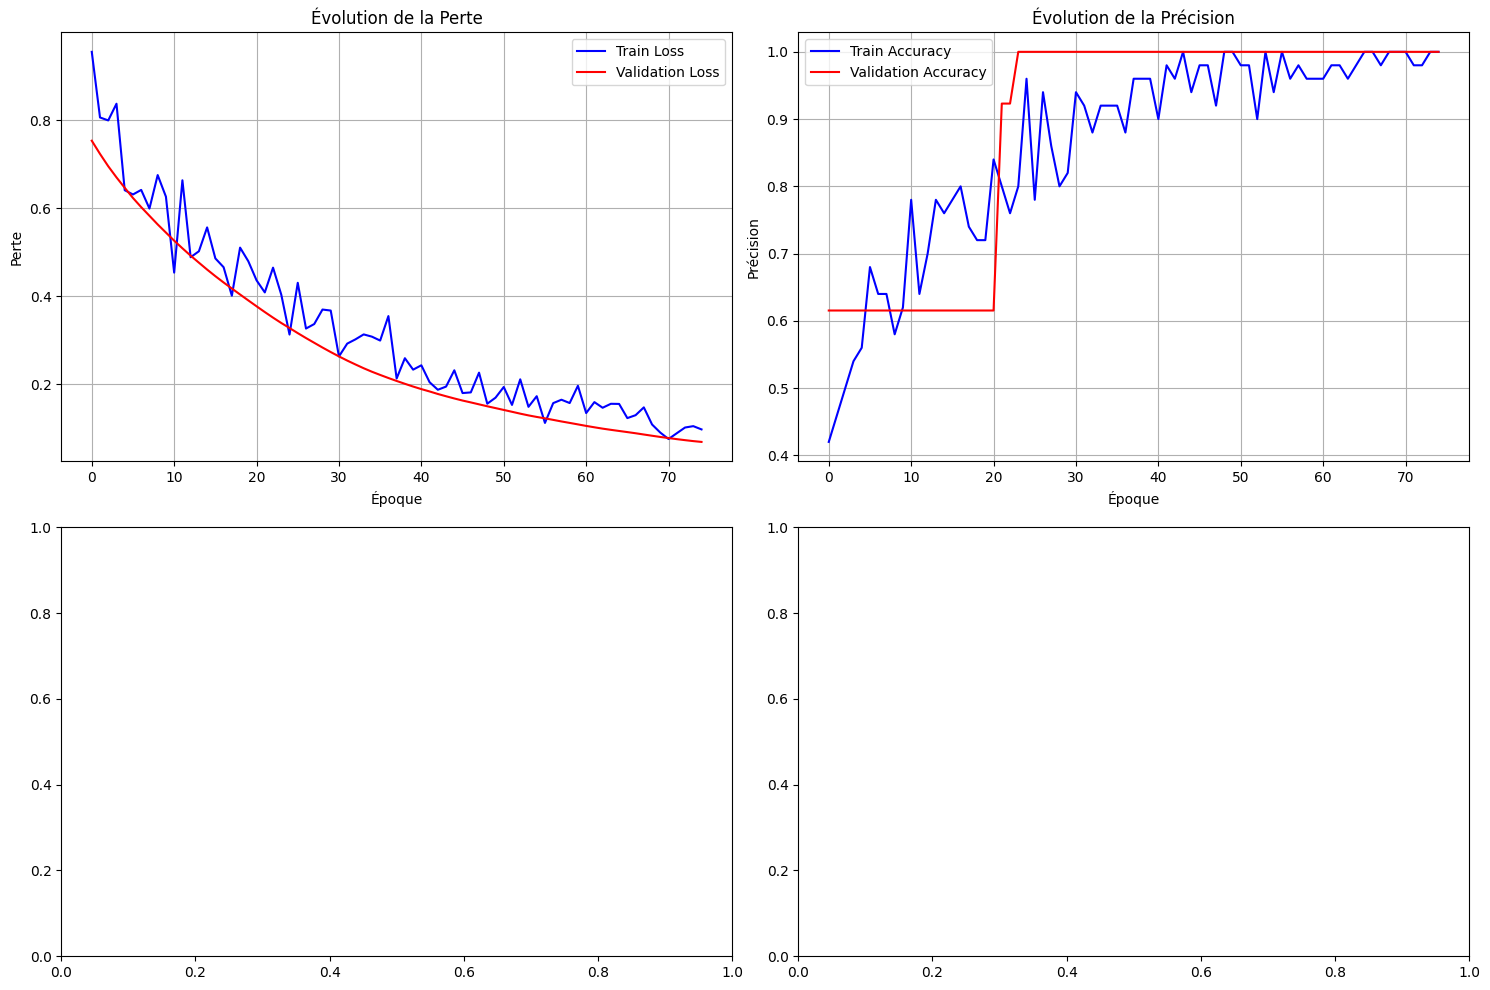

In [ ]:
def plot_training_history(history):
    """
    Affiche les courbes d'entra√Ænement
    """
    if history is None:
        return
        
    print(f"\nüìà VISUALISATION DES COURBES D'ENTRA√éNEMENT")
    print("=" * 50)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Courbe de perte (loss)
    axes[0, 0].plot(history.history['loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axes[0, 0].set_title('√âvolution de la Perte')
    axes[0, 0].set_xlabel('√âpoque')
    axes[0, 0].set_ylabel('Perte')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Courbe de pr√©cision (accuracy)
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0, 1].set_title('√âvolution de la Pr√©cision')
    axes[0, 1].set_xlabel('√âpoque')
    axes[0, 1].set_ylabel('Pr√©cision')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Courbe de pr√©cision (precision)
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Train Precision', color='blue')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', color='red')
        axes[1, 0].set_title('√âvolution de la Pr√©cision (Precision)')
        axes[1, 0].set_xlabel('√âpoque')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Courbe de rappel (recall)
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Train Recall', color='blue')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', color='red')
        axes[1, 1].set_title('√âvolution du Rappel (Recall)')
        axes[1, 1].set_xlabel('√âpoque')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Affichage des courbes
if history is not None:
    plot_training_history(history)

## Evaluation du mod√®le sur le jeu de test 


 √âVALUATION SUR LE JEU DE TEST
 G√©n√©ration des pr√©dictions...
1/1 [==============================] - 4s 4s/step

 M√âTRIQUES DE PERFORMANCE:
   Accuracy:  1.0000 (100.00%)
   Precision: 1.0000 (100.00%)
   Recall:    1.0000 (100.00%)
    F1-Score:  1.0000 (100.00%)


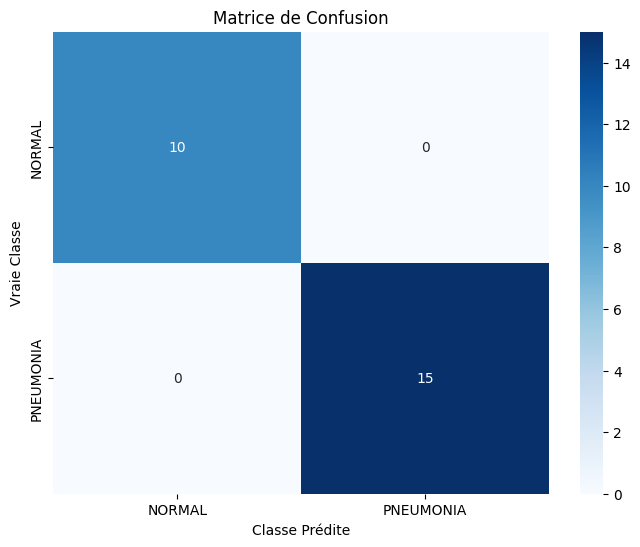


 RAPPORT DE CLASSIFICATION D√âTAILL√â:
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00        10
   PNEUMONIA       1.00      1.00      1.00        15

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

 M√©triques de test logg√©es dans MLflow


In [ ]:
def evaluate_model(model, test_generator):
    """
    √âvalue le mod√®le sur le jeu de test et affiche les m√©triques
    """
    if model is None or test_generator is None:
        return
        
    print(f"\n √âVALUATION SUR LE JEU DE TEST")
    print("=" * 50)
    
    # Pr√©dictions sur le jeu de test
    print(" G√©n√©ration des pr√©dictions...")
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    
    # R√©cup√©ration des vraies labels
    true_labels = test_generator.classes
    
    # Conversion des pr√©dictions en classes binaires
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    
    # Calcul des m√©triques
    accuracy = accuracy_score(true_labels, predicted_classes)
    precision = precision_score(true_labels, predicted_classes)
    recall = recall_score(true_labels, predicted_classes)
    f1 = f1_score(true_labels, predicted_classes)
    
    print(f"\n M√âTRIQUES DE PERFORMANCE:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"    F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    
    # Matrice de confusion
    cm = confusion_matrix(true_labels, predicted_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NORMAL', 'PNEUMONIA'], 
                yticklabels=['NORMAL', 'PNEUMONIA'])
    plt.title('Matrice de Confusion')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Pr√©dite')
    plt.show()
    
    # Rapport de classification d√©taill√©
    print(f"\n RAPPORT DE CLASSIFICATION D√âTAILL√â:")
    print(classification_report(true_labels, predicted_classes, 
                              target_names=['NORMAL', 'PNEUMONIA']))
    
    # Log des m√©triques dans MLflow si disponible
    if mlflow_ready:
        try:
            with mlflow.start_run():
                mlflow.log_metrics({
                    "test_accuracy": accuracy,
                    "test_precision": precision,
                    "test_recall": recall,
                    "test_f1_score": f1
                })
            print(" M√©triques de test logg√©es dans MLflow")
        except:
            print("  Impossible de logger dans MLflow")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# √âvaluation du mod√®le
if model is not None and test_gen is not None:
    test_results = evaluate_model(model, test_gen)
else:
    test_results = None
    print("  √âvaluation impossible - v√©rifiez le mod√®le et les donn√©es de test")

## Sauvegarde du mod√®le

In [ ]:
def save_model(model, filename="densenet121_pneumonia_model.h5"):
    """
    Sauvegarde le mod√®le entra√Æn√©
    """
    if model is None:
        return
        
    print(f"\n SAUVEGARDE DU MOD√àLE")
    print("=" * 50)
    
    try:
        model.save(filename)
        print(f" Mod√®le sauvegard√©: {filename}")
        print(f" Taille du fichier: {os.path.getsize(filename) / (1024*1024):.1f} MB")
    except Exception as e:
        print(f" Erreur lors de la sauvegarde: {e}")

# Sauvegarde du mod√®le
if model is not None:
    save_model(model)


 SAUVEGARDE DU MOD√àLE


c:\Users\Utilisateur\Desktop\CNN_Tranfert_Learning\pneumonia_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 Mod√®le sauvegard√©: densenet121_pneumonia_model.h5
 Taille du fichier: 31.4 MB
